<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Lesson_4_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 4: 

https://course.fast.ai/videos/?lesson=

In lesson 4 we'll dive in to natural language processing (NLP), using the IMDb movie review dataset. In this task, our goal is to predict whether a movie review is positive or negative; this is called sentiment analysis. We'll be using the ULMFiT algorithm, which was originally developed during the fast.ai 2018 course, and became part of a revolution in NLP during 2018 which led the New York Times to declare that new systems are starting to crack the code of natural language. ULMFiT is today the most accurate known sentiment analysis algorithm.

The basic steps are:

Create (or, preferred, download a pre-trained) language model trained on a large corpus such as Wikipedia (a "language model" is any model that learns to predict the next word of a sentence)
Fine-tune this language model using your target corpus (in this case, IMDb movie reviews)
Extract the encoder from this fine tuned language model, and pair it with a classifier. Then fine-tune this model for the final classification task (in this case, sentiment analysis).
After our journey into NLP, we'll complete our practical applications for Practical Deep Learning for Coders by covering tabular data (such as spreadsheets and database tables), and collaborative filtering (recommendation systems).

For tabular data, we'll see how to use categorical and continuous variables, and how to work with the fastai.tabular module to set up and train a model.

Then we'll see how collaborative filtering models can be built using similar ideas to those for tabular data, but with some special tricks to get both higher accuracy and more informative model interpretation.

This brings us to the half-way point of the course, where we have looked at how to build and interpret models in each of these key application areas:

* Computer vision
* NLP
* Tabular
* Collaborative filtering

For the second half of the course, we'll learn about how these models really work, and how to create them ourselves from scratch. For this lesson, we'll put together some of the key pieces we've touched on so far:

* Activations
* Parameters
* Layers (affine and non-linear)
* Loss function.

We'll be coming back to each of these in lots more detail during the remaining lessons. We'll also learn about a type of layer that is important for NLP, collaborative filtering, and tabular models: the embedding layer. As we'll discover, an "embedding" is simply a computational shortcut for a particular type of matrix multiplication (a multiplication by a one-hot encoded matrix).

## Install 

In [0]:
!pip install imgaug==0.2.7

!pip install --upgrade pandas

!pip install --upgrade numpy

!curl -s https://course.fast.ai/setup/colab | bash

## Constants & global flaggs

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

bs = 64
# bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Import Fast.ai & PyTorch


In [6]:
import fastai
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.collab import *
from fastai.tabular import *

import matplotlib.pyplot as plt
from PIL import Image

print("FastAI Version: " + str(fastai.__version__))


FastAI Version: 1.0.51


In [4]:
import torch

print("PyTorch Version: " + str(torch.__version__))

PyTorch Version: 1.0.1.post2


## Check GPU *acceleration*

In [60]:
torch.cuda.current_device()

print("Cude available: " + str(torch.cuda.is_available()))
print("Cude enabled:" + str(torch.backends.cudnn.enabled))

#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print("GPU used: " + torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Cude available: True
Cude enabled:True
Using device: cuda

GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Collaborative filtering example¶


In [20]:
user,item,title = 'userId','movieId','title'
path = untar_data(URLs.ML_SAMPLE)
path


PosixPath('/content/data/movie_lens_sample')

In [9]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [0]:
learn.lr_find()


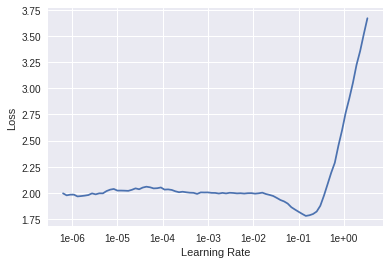

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.619170,0.912886,00:00
1,0.852577,0.667106,00:00
2,0.658264,0.661872,00:00


In [18]:
lr = 5e-3
learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,time
0,0.457504,0.631245,00:01
1,0.446589,0.629249,00:00
2,0.379335,0.621954,00:00
3,0.308871,0.624037,00:00
4,0.265614,0.624205,00:00


## Movielens 100k¶


In [0]:
! wget http://files.grouplens.org/datasets/movielens/ml-100k.zip


In [0]:
!unzip ml-100k.zip -d data
! ls data

In [61]:
path=Config.data_path()/'ml-100k'
path

PosixPath('/root/.fastai/data/ml-100k')

In [33]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [34]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
len(ratings)


100000

In [36]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)
#  data.show_batch()


In [0]:
y_range = [0,5.5]

learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


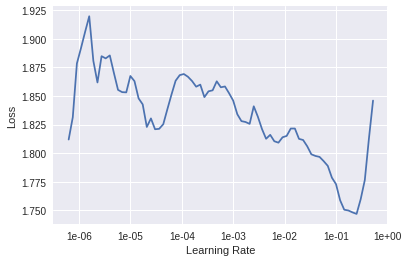

In [39]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [65]:
lr = 5e-3
learn.fit_one_cycle(5, lr)


epoch,train_loss,valid_loss,time
0,0.455102,0.853686,00:12
1,0.584251,0.870144,00:12
2,0.551647,0.852423,00:12
3,0.442686,0.847266,00:13
4,0.349300,0.849066,00:13


In [64]:
learn.unfreeze() # retrain the entire net

lr = 5e-3
learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,time
0,0.603688,0.835665,00:12
1,0.659945,0.848488,00:12
2,0.594298,0.832974,00:13
3,0.503372,0.829772,00:12
4,0.405878,0.831257,00:12


In [0]:
learn.save('dotprod')


In [42]:
learn.load('dotprod');
learn.model


EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

## Bias

In [44]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

In [45]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]


In [0]:
sorted(movie_ratings, key=item0)[:15]


## Weights 

In [49]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [50]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]


[(tensor(1.2385), 'Jungle2Jungle (1997)'),
 (tensor(1.2099), 'Home Alone 3 (1997)'),
 (tensor(1.1965), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.1772), 'Congo (1995)'),
 (tensor(1.1683), "McHale's Navy (1997)"),
 (tensor(1.1336), 'Bio-Dome (1996)'),
 (tensor(1.1334), 'Leave It to Beaver (1997)'),
 (tensor(1.1284), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.1018), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.0778), 'Mortal Kombat: Annihilation (1997)')]

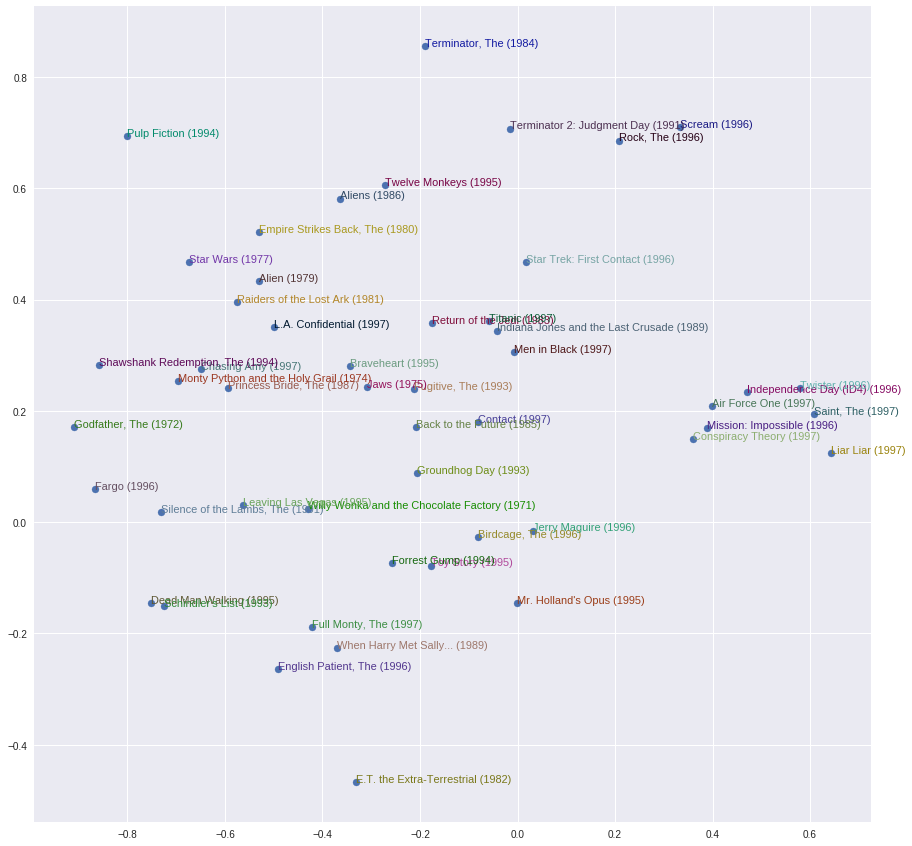

In [53]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Tabular models¶


In [0]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [0]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [FillMissing, Categorify, Normalize]

In [0]:
test = TabularList.from_df(df.iloc[800:1000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)


In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


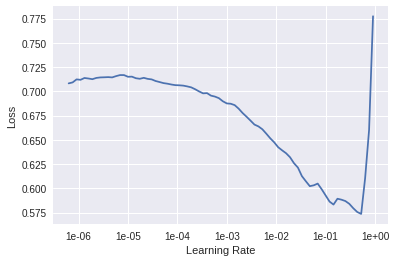

In [71]:
learn.lr_find()
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(5, 5e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.369557,0.404467,0.805000,00:06
1,0.353106,0.385963,0.810000,00:06
2,0.364399,0.371321,0.820000,00:06
3,0.355215,0.371376,0.830000,00:06
4,0.350540,0.366945,0.835000,00:06


In [73]:
learn.fit_one_cycle(5, 1e-07)


epoch,train_loss,valid_loss,accuracy,time
0,0.355082,0.368479,0.835000,00:06
1,0.362370,0.369583,0.835000,00:06
2,0.345531,0.364905,0.835000,00:06
3,0.350044,0.367467,0.835000,00:06
4,0.344163,0.366818,0.835000,00:06


In [74]:
learn.fit_one_cycle(5, slice(2e-3))


epoch,train_loss,valid_loss,accuracy,time
0,0.350960,0.371385,0.840000,00:06
1,0.345437,0.369471,0.820000,00:06
2,0.348197,0.352591,0.840000,00:06
3,0.339760,0.348937,0.835000,00:06
4,0.343047,0.353553,0.835000,00:06


In [75]:
learn.fit(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.353654,0.357160,0.840000,00:06


##Inference

In [0]:
row = df.iloc[0]


In [77]:
learn.predict(row)


(Category >=50k, tensor(1), tensor([0.4770, 0.5230]))